In [1]:
import cPickle as cp

from IPython.display import Image
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.mlab import bivariate_normal

import numpy as np

import tensorflow as tf

from sklearn.metrics import accuracy_score

%matplotlib inline

In [5]:
dim = 2
plot_x_lim = 10.
plot_y_lim = 10.
x = np.arange(-plot_x_lim, plot_x_lim, 0.1)
y = np.arange(-plot_y_lim, plot_y_lim, 0.1)
X, Y = np.meshgrid(x, y)

### The Beta Divergence

The *Beta divergence* [[1](https://www.jstor.org/stable/2337385?seq=1#page_scan_tab_contents), [2](https://www.researchgate.net/profile/Shinto_Eguchi/publication/228561230_Robustifing_maximum_likelihood_estimation_by_psi-divergence/links/545d65910cf2c1a63bfa63e6/Robustifing-maximum-likelihood-estimation-by-psi-divergence.pdf), [3](https://papers.nips.cc/paper/4922-robust-spatial-filtering-with-beta-divergence.pdf)] is a robust measure of the distance between two distributions.  The distributions are exponentiated as $p^{\beta}(\mathbf{x})$, and thus increasing $\beta$ results in more dramatic mode-seeking behavior.  In other words, if a data point has low probability under the model, exponentiating further decreases its probability, and in turn, its effect on model fitting.  The model, in a sense, can forget data.  The full divergence between a distribution $p(\mathbf{x})$ and a model $q(\mathbf{x};\boldsymbol{\theta})$ is:

$$\text{D}_{\beta}[ \ p(\mathbf{x}) \  || \ q(\mathbf{x};\boldsymbol{\theta}) \ ] = \frac{1}{\beta}\mathbb{E}_{p}[p^{\beta}(\mathbf{x}) - q^{\beta}(\mathbf{x};\boldsymbol{\theta})] - \frac{1}{\beta + 1} \int_{\mathbf{x}} p^{\beta + 1}(\mathbf{x}) - q^{\beta + 1}(\mathbf{x};\boldsymbol{\theta}) d\mathbf{x}.$$  Assuming $\hat{p}(\mathbf{x})$ is the empirical data distribution, we have the equivalent objective:

$$\tilde{\text{D}}_{\beta}[ \ \hat{p}(\mathbf{x}) \  || \ q(\mathbf{x}_{i};\boldsymbol{\theta}) \ ] =  \frac{1}{\beta + 1} \mathbb{E}_{q}[q^{\beta}(\mathbf{x};\boldsymbol{\theta})] -\frac{1}{N} \sum_{i=1}^{N}  (e^{\beta \log q(\mathbf{x}_{i};\boldsymbol{\theta})} - 1)/\beta .$$

### Experiment
##### A Mispecified Model with Outliers
Let's draw data from a Student-T and add some outliers drawn from a shifted Cauchy.

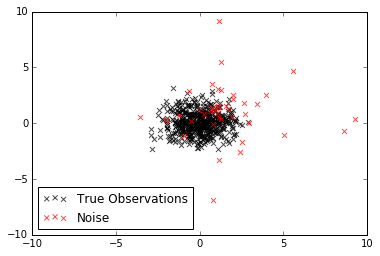

In [22]:
### Make Dataset
N_true = 500
N_outlier = 50
N = N_true + N_outlier

true_obs = np.random.standard_t(df=100, size=(N_true, dim))
noise_obs = np.random.standard_cauchy(size=(N_outlier, dim)) + 1.
data = np.vstack([true_obs, noise_obs])
np.random.shuffle(data)

plt.scatter(true_obs[:,0], true_obs[:,1], marker='x', s=25, c='k', alpha=.7, label="True Observations")
plt.scatter(noise_obs[:,0], noise_obs[:,1], marker='x', s=25, c='r', alpha=.7, label="Noise")

plt.xlim([-plot_x_lim, plot_x_lim])
plt.ylim([-plot_y_lim, plot_y_lim])
plt.legend(loc=3)
plt.show()

Now let's see what a Gaussian fit **just** to the data, not the noise, looks like.

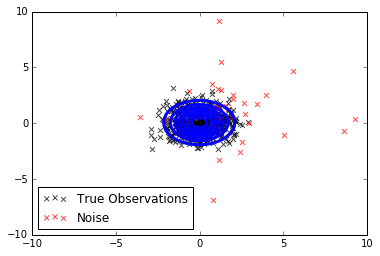

In [23]:
### Fit Gaussian Model to True Data
mu = np.mean(true_obs, axis=0)
sigma = np.cov(true_obs.T)

### Plot
plt.scatter(true_obs[:,0], true_obs[:,1], marker='x', s=25, c='k', alpha=.7, label="True Observations")
plt.scatter(noise_obs[:,0], noise_obs[:,1], marker='x', s=25, c='r', alpha=.7, label="Noise")

Z = bivariate_normal(X, Y, sigmax=np.sqrt(sigma[0,0]), sigmay=np.sqrt(sigma[1,1]), mux=mu[0], muy=mu[1], sigmaxy=sigma[0,1])
plt.contour(X,Y,Z, colors='blue', linewidths=3)

plt.xlim([-plot_x_lim, plot_x_lim])
plt.ylim([-plot_y_lim, plot_y_lim])
plt.legend(loc=3)
plt.show()

##### Maximum Likelihood Estimate
Now let's fit a Gaussian model to the full dataset...

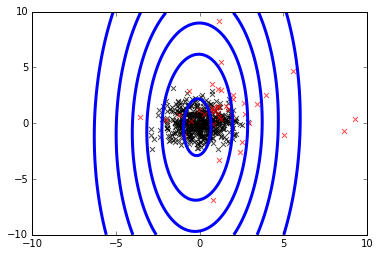

In [24]:
mu = np.mean(data, axis=0)
sigma = np.cov(data.T)

plt.scatter(true_obs[:,0], true_obs[:,1], marker='x', s=25, c='k', alpha=.7)
plt.scatter(noise_obs[:,0], noise_obs[:,1], marker='x', s=25, c='r', alpha=.7)

Z = bivariate_normal(X, Y, sigmax=np.sqrt(sigma[0,0]), sigmay=np.sqrt(sigma[1,1]), mux=mu[0], muy=mu[1], sigmaxy=sigma[0,1])
plt.contour(X,Y,Z, colors='blue', linewidths=3)

plt.xlim([-plot_x_lim, plot_x_lim])
plt.ylim([-plot_y_lim, plot_y_lim])
plt.show()

As is clear, the model fit is dramatically affected by the noise.

##### Bootstrap Estimate

Let's see how bootstrapping does...

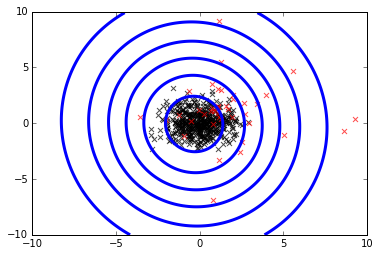

In [26]:
def uniform_bootstrap_resample(X, n=None, labels=None):
    """ Bootstrap resample an array_like
        Parameters
        ----------
        X : array_like
        data to resample
        n : int, optional
        length of resampled array, equal to len(X) if n==None
        Results
        -------
        returns X_resamples
        """
    if n == None:
        n = len(X)
    resample_i = np.floor(np.random.rand(n)*len(X)).astype(int)
    X_resample = X[resample_i]
    if labels != None:
        Y_resample = labels[resample_i]
        return X_resample, Y_resample
    return X_resample


### Get Bootstrap Estimates
K = 3
mu_avg = np.zeros((dim,))
sigma_avg = np.zeros((dim,dim))

for k in xrange(K):
    X_k = uniform_bootstrap_resample(data, N)
    mu_avg += np.mean(X_k, axis=0)
    sigma_avg += np.cov(X_k.T)
mu_avg /= K
sigma_avg /= K


### Plot
plt.scatter(true_obs[:,0], true_obs[:,1], marker='x', s=25, c='k', alpha=.7)
plt.scatter(noise_obs[:,0], noise_obs[:,1], marker='x', s=25, c='r', alpha=.7)

Z = bivariate_normal(X, Y, sigmax=np.sqrt(sigma_avg[0,0]), sigmay=np.sqrt(sigma_avg[1,1]), mux=mu_avg[0], muy=mu_avg[1], sigmaxy=sigma_avg[0,1])
plt.contour(X,Y,Z, colors='blue', linewidths=3)

plt.xlim([-plot_x_lim, plot_x_lim])
plt.ylim([-plot_y_lim, plot_y_lim])
plt.show()

This is better but still significantly over dispersed by the noise.

##### Beta Divergence

Finally, let's try using a robust diverenge for model fitting...

In [27]:
def log_normal_pdf(x, mu, sigma):
    d = mu - x
    d2 = tf.mul(-1., tf.mul(d,d))
    s2 = tf.mul(2., tf.mul(sigma,sigma))
    return tf.reduce_sum(tf.div(d2,s2) - tf.log(tf.mul(sigma, 2.506628)), reduction_indices=1, keep_dims=True)

### Make variables
X_train = tf.placeholder("float", [None, dim]) # data
mu = tf.Variable(tf.ones([1, dim])*5.)
log_sigma = tf.Variable(tf.zeros((1,2)))

### Sample from model
X_samples = mu + tf.exp(log_sigma) * tf.random_normal(shape=(100, dim))

### Define Beta Divergence
beta = .1
beta_obj = tf.reduce_mean((tf.exp(beta * log_normal_pdf(X_train, mu, tf.exp(log_sigma))) - 1.)/beta) 
beta_obj -= tf.reduce_mean((1./(1. + beta)) * tf.exp(beta * log_normal_pdf(X_samples, mu, tf.exp(log_sigma))))

In [28]:
# Set training params
n_epochs = 500
learning_rate = .1

# get the training operator
train_model = tf.train.AdamOptimizer(learning_rate).minimize(-beta_obj, var_list=[mu, log_sigma])

with tf.Session() as session:
    tf.initialize_all_variables().run()
    
    for epoch_idx in xrange(n_epochs):
        
        # perform update
        _, obj = session.run([train_model, beta_obj], feed_dict={X_train: data})
        if (epoch_idx+1) % 50 == 0:
            print "Epoch %d.  Beta Div. Objective: %.3f" %(epoch_idx+1, obj)
        
    # save the final params
    final_params = {'mu':session.run(mu), 'sigma':session.run(tf.exp(log_sigma))}

Epoch 50.  Beta Div. Objective: -4.452
Epoch 100.  Beta Div. Objective: -3.450
Epoch 150.  Beta Div. Objective: -3.420
Epoch 200.  Beta Div. Objective: -3.428
Epoch 250.  Beta Div. Objective: -3.415
Epoch 300.  Beta Div. Objective: -3.431
Epoch 350.  Beta Div. Objective: -3.428
Epoch 400.  Beta Div. Objective: -3.421
Epoch 450.  Beta Div. Objective: -3.419
Epoch 500.  Beta Div. Objective: -3.432


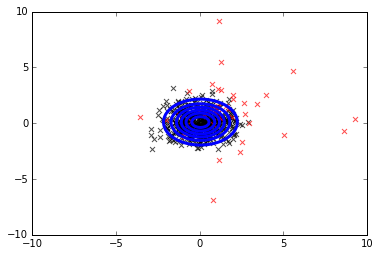

In [29]:
plt.scatter(true_obs[:,0], true_obs[:,1], marker='x', s=25, c='k', alpha=.7)
plt.scatter(noise_obs[:,0], noise_obs[:,1], marker='x', s=25, c='r', alpha=.7)

Z = bivariate_normal(X, Y, sigmax=final_params['sigma'][0,0], sigmay=final_params['sigma'][0,1], mux=final_params['mu'][0,0], muy=final_params['mu'][0,1], sigmaxy=0.)
plt.contour(X,Y,Z, colors='blue', linewidths=3)

plt.xlim([-plot_x_lim, plot_x_lim])
plt.ylim([-plot_y_lim, plot_y_lim])
plt.show()

We see that the Beta divergence finally allows us to recover the data from the noise, and the model looks like the first one above.